### 1. Import modules

In [117]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC

### 2. Data preprocessing functions

This includes
- Converting dates to timestamps
- Calculating all the Gustas things for the previous _n_ games

In [124]:
METRICS = {
    "GoalsFullTime": ("FTHG", "FTAG"),
    "GoalsHalfTime": ("HTHG", "HTAG"),
    "GustasPoints":  ("HomePoints", "AwayPoints"),
    "GoalShots":     ("HS",   "AS"),
    "TargetShots":   ("HST",  "AST"),
    "Corners":       ("HC",   "AC"),
    "YellowCards":   ("HY",   "AY"),
    "RedCards":      ("HR",   "AR")
}


def create_date_stamp(date_string: str) -> int:
    # Transforms a dd/mm/yy or dd/mm/yyyy string to a timestamp
    if len(date_string.split("/")[-1]) == 4:
        return int(datetime.strptime(date_string, "%d/%m/%Y").timestamp())
    else:
        return int(datetime.strptime(date_string, "%d/%m/%y").timestamp())


def group_seasons(df: pd.DataFrame) -> np.array:
    # Adds a column to the df indicating which season it is
    seasons = []
    season_counter = 1
    prev_season_index = 0
    rows = df.iterrows()
    next(rows)

    for i, game in rows:
        if game.Date[4] == "8" and df.iloc[i - 1].Date[4] == "5":
            seasons += [season_counter]*(i - prev_season_index)
            season_counter += 1
            prev_season_index = i

    return pd.DataFrame({"Season": seasons})


def generate_gustas_points(df: pd.DataFrame) -> pd.DataFrame:
    # Caluclate Gustas' points for each game
    points = {"HomePoints": [0]*len(df), "AwayPoints": [0]*len(df)}
    score_map = {"H": (3, 0), "A": (0, 3), "D": (1, 1)}

    for i, (_, game) in enumerate(df.iterrows()):
        points["HomePoints"][i], points["AwayPoints"][i] = score_map[game["FTR"]]

    return pd.DataFrame(points)
            

def calculate_season_metrics(df: pd.DataFrame, teams: [str], metric: str) -> pd.DataFrame:
    # Translates metrics from home-away data to team data
    # The df will be across an entire season
    global METRICS
    metric_by_team = {}

    for team in teams:
        home_games = df[df["HomeTeam"] == team]
        away_games = df[df["AwayTeam"] == team]
        print(metric)
        print(home_games[METRICS[metric][0]].sum())

        metric_by_team[team] = home_games[METRICS[metric][0]].sum() + away_games[METRICS[metric][1]].sum()

    return metric_by_team


def generate_previous_season_stats(curr: pd.DataFrame, prev: pd.DataFrame, teams: [str]) -> pd.DataFrame:
    # Includes the metrics for the previous season in each game of the current
    # args:
    # - curr: the current season
    # - prev: the previous season
    # - teams: the list of all teams
    # 
    # returns
    # A dataframe whose columns are named 'HomePST{metric}' and 'AwayPST{metric}'
    global METRICS
    prev_season_metrics = { m : calculate_season_metrics(prev, teams, m) for m in METRICS }
    metrics_df = {}

    for metric in METRICS:
        metrics_df[f"HomePST{metric}"] = []
        metrics_df[f"AwayPST{metric}"] = []

    for _, game in curr.iterrows():
        home = game["HomeTeam"]
        away = game["AwayTeam"]

        for metric in METRICS:
            metrics_df[f"HomePST{metric}"].append(prev_season_metrics[metric][home])
            metrics_df[f"AwayPST{metric}"].append(prev_season_metrics[metric][away])

    df = pd.DataFrame(metrics_df)
    df.index = curr.index

    return df


def combine_previous_season_stats(df: pd.DataFrame) -> pd.DataFrame:
    # Creates a dataframe that includes df and the stats from
    # the previous season
    new_df = None
    teams = df["HomeTeam"].unique()

    for i in range(1, int(df["Season"].max())):
        curr = df[df["Season"] == i]
        prev = df[df["Season"] == i - 1]
        res = generate_previous_season_stats(curr, prev, teams)

        if new_df is None:
            new_df = res
        else:
            new_df = pd.concat([new_df, res])

    return df.join(new_df)


def format_df(df: pd.DataFrame) -> pd.DataFrame:
    # Applies all feature engineering etc that one could want
    df["DateStamp"] = df["Date"].map(create_date_stamp)
    df = df.join(group_seasons(df)).join(generate_gustas_points(df))

    return combine_previous_season_stats(df)
    

### 3. Load training and testing data

In [125]:
# Define features etc
FEATURES = [
    "HomeTeam",
    "AwayTeam",
    "Referee",
    "DateStamp",
    "HomePSTGoalsFullTime",
    "HomePSTGoalsHalfTime",
    "HomePSTGustasPoints",
    "HomePSTGoalShots",
    "HomePSTTargetShots",
    "HomePSTCorners",
    "HomePSTYellowCards",
    "HomePSTRedCards",
    "AwayPSTGoalsFullTime",
    "AwayPSTGoalsHalfTime",
    "AwayPSTGustasPoints",
    "AwayPSTGoalShots",
    "AwayPSTTargetShots",
    "AwayPSTCorners",
    "AwayPSTYellowCards",
    "AwayPSTRedCards"
]

CATEGORICAL_FEATURES = ["HomeTeam", "AwayTeam", "Referee"]

TARGET_NAMES = ["A", "D", "H"] # for presenting data


# Load datasets
df = format_df(pd.read_csv("data/epl-training.csv").dropna())
df.fillna(0, inplace=True)

df["FTR"] = df["FTR"].astype(str)

for ft in CATEGORICAL_FEATURES:
    df[ft] = df[ft].astype(str)


# Split X and y, training and testing

X = df[FEATURES]
y = df["FTR"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numerical_features = [f for f in FEATURES if f not in CATEGORICAL_FEATURES]
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), CATEGORICAL_FEATURES)
    ])
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)



GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsFullTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHalfTime
0
GoalsHal

ValueError: invalid literal for int() with base 10: '19/08/00'

### 4. Create SVM model

Specifically, we are going to fit our model to our data and then predict the testing results

In [112]:
clf = SVC(probability=False)
clf.fit(X=X_train, y=y_train)

y_pred = clf.predict(X_test)

### 5. Get performance metrics

We're going to print a classification report and print some graphs and charts now

/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/conrad/UCL/Modules/COMP0036-ML/Coursework/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

              precision    recall  f1-score   support

           A       0.56      0.44      0.49       516
           D       0.00      0.00      0.00       460
           H       0.51      0.89      0.65       792

    accuracy                           0.52      1768
   macro avg       0.36      0.44      0.38      1768
weighted avg       0.39      0.52      0.43      1768



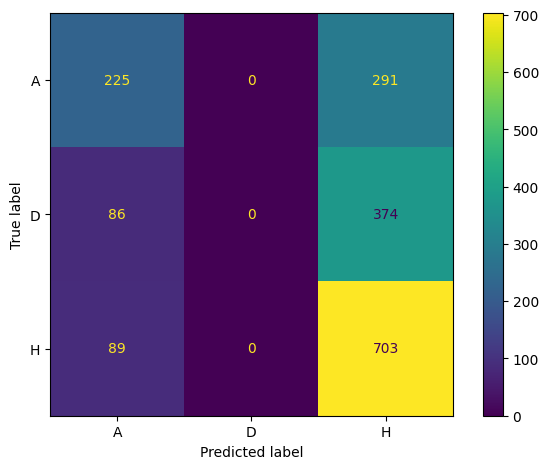

In [115]:
def evaluate_model(y_test, y_pred, target_names):
    print(classification_report(y_test, y_pred, target_names=target_names))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names)
    plt.tight_layout()
    plt.show()


evaluate_model(y_test, y_pred, TARGET_NAMES)